https://bit.ly/DSNN-2

# Лекция 2. Углубление в НС и библиотеку Keras


In [19]:
!pip install 

ERROR: You must give at least one requirement to install (see "pip help install")


In [20]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Introduction

На прошлой лекции мы познакомились с базовым набором инструментов библиотеки Keras, научились строить модели с помощью инструмента ```keras.Sequential()```. Однако на практике не все модели удается реализовать с помощью этого метода.

Если в модели присутствует "нелинейная" структура (т.е. есть разветвление потока данных), то ```keras.Sequential()``` не подойдет для построения такой модели. На помощь приходит инструмент *functional API*.


Рассмотрим следующую модель:

<div class="k-default-codeblock">
```
(input: 784-dimensional vectors)
       ↧
[Dense (32 units, relu activation)]
       ↧
[Dense (32 units, relu activation)]
       ↧
[Dense (10 units, softmax activation)]
       ↧
(output: logits of a probability distribution over 10 classes)
```
</div>

Обычно в глубоком обучении принято использовать следующую структуру во входных данных:

$$[n, W,H, N_{ch}],$$

где $n$ - размер подвыборки (batch_size), $N_{ch}$ - кол-во каналов (красный, зеленый, синий), $W$, $H$ - ширина и высота изображения. Однако batch_size не указывается при объявлении слоев в Keras. 



In [21]:
img_inputs = keras.Input(shape=(32, 32, 3))
print(img_inputs.shape)

(None, 32, 32, 3)


На сегодняшний день мы пока забудем о вышеописанной структуре и будем все входные данные трактовать как один длинный вектор длины $(W \cdot H \cdot N_{ch})$.

In [22]:
img_inputs = keras.Input(shape=(28, 28))
inputs = layers.Flatten()(img_inputs)
inputs

<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'flatten_1')>

Следующий слой, который будет использовать тензор `inputs` как входные данные, должен быть объявлен следующим образом:


In [23]:
x = layers.Dense(32)(inputs) ### объявление слоя
x = layers.BatchNormalization()(x) #
x = layers.Dropout(0.5)(x)

x = layers.Activation('relu')(x)
#x = dense1(inputs) ### указание входного тензора

y = layers.Dense(32)(inputs)
y = layers.BatchNormalization()(y)
y = layers.Dropout(0.5)(y)
y = layers.Activation('relu')(y)

dense21 = layers.Dense(32, activation="relu")(x)
dense22 = layers.Dense(32, activation='relu')(y)

dense3 = layers.Add()([dense21, dense22])

In [24]:
x = layers.Dense(32, activation="relu")(dense3)
outputs = layers.Dense(10)(x)

На этом этапе мы можем закончить добавление новых блоков и объявить модель, которая будет состоять из данных слоёв:

In [25]:
model = keras.Model(inputs=img_inputs, outputs=outputs, name="our_first_model")

In [26]:
model.summary()

Model: "our_first_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten_1 (Flatten)            (None, 784)          0           ['input_4[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 32)           25120       ['flatten_1[0][0]']              
                                                                                                  
 dense_7 (Dense)                (None, 32)           25120       ['flatten_1[0][0]']              
                                                                                    

Можно, например, нарисовать модель в виде направленного графа:

In [27]:
keras.utils.plot_model(model, "my_first_model.png")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [28]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


## Обучение модели

Обучение модели происходит тем же самым образом, что и модели, объявленной с помощью класса ```Sequential()```, т.е. с помощью метода ```fit()```.


In [29]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train.shape

(60000, 28, 28)

In [30]:
x_train = x_train / 255.0 # delim na float
x_test = x_test / 255.0

In [31]:
y_train  # Для SparseCategoricalCrossentropy,metki klassov

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [ ]:
keras.utils.to_categorical(y_train)  # Для CategoricalCrossEntropy, metk klassov pereveli v binarnoe predstavlenije

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [33]:
# SparseCategoricalCrossentropy- schitajem funkziju poter 
# optimizator - SGD - stahosticheskij gradientnqj spusk, obuchajetsja na skuchainqh objektah, momentum - budet smotret na istoriju shagov
#     RMSprop - mozno izmenjat rho - skolko mq berjom tekushih i nakoplennqh gradientov
#     Adam - beta_1: izmenenije traekorii , beta_2: nakaplibanije gradientov
# metrics=["accuracy"] - schitajem dolju pravelnqh otvetov
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # from_logits=True, potomu chto na vqhodnom sloe funkzii aktivazii net
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)
# mq hotim pozze ottestiroat test vqborku, poetomu ukazqvaem validation_split, iz train 80% na obuchenije , 20% na validaziju 
# to est iz obuchenija delaem 2 podvqborki 
history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_split=0.2)

test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])
# 750 iterazij, model pomenjat vesa 750 raz = 750 shagov gradijentnogo spuska 
# loss padajet, accuracy rastjot, val_accuracy - vsegda horosho chto rastjot 


# HINT !!! chtobq obuchenije proishodilo bqstree perehodim na videkartu = GPU , dlja eto v Google colab  menjaem runtain na GPU 

Epoch 1/10
750/750 [==============================] - 3s 2ms/step - loss: 0.6497 - accuracy: 0.8010 - val_loss: 0.2325 - val_accuracy: 0.9311
Epoch 2/10
750/750 [==============================] - 1s 1ms/step - loss: 0.4034 - accuracy: 0.8786 - val_loss: 0.2003 - val_accuracy: 0.9402
Epoch 3/10
750/750 [==============================] - 1s 1ms/step - loss: 0.3590 - accuracy: 0.8917 - val_loss: 0.1773 - val_accuracy: 0.9475
Epoch 4/10
750/750 [==============================] - 1s 1ms/step - loss: 0.3302 - accuracy: 0.9007 - val_loss: 0.1689 - val_accuracy: 0.9498
Epoch 5/10
750/750 [==============================] - 1s 1ms/step - loss: 0.3071 - accuracy: 0.9074 - val_loss: 0.1601 - val_accuracy: 0.9513
Epoch 6/10
750/750 [==============================] - 1s 1ms/step - loss: 0.2941 - accuracy: 0.9109 - val_loss: 0.1554 - val_accuracy: 0.9537
Epoch 7/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2845 - accuracy: 0.9134 - val_loss: 0.1476 - val_accuracy: 0.9582
Epoch 

In [34]:
history.history

{'loss': [0.6497141122817993,
  0.40338170528411865,
  0.3590148091316223,
  0.33015596866607666,
  0.3070976436138153,
  0.294050931930542,
  0.28448486328125,
  0.2782333493232727,
  0.272167831659317,
  0.2672407329082489],
 'accuracy': [0.8009999990463257,
  0.8786458373069763,
  0.8917291760444641,
  0.9007291793823242,
  0.9073749780654907,
  0.910895824432373,
  0.9133541584014893,
  0.9159791469573975,
  0.917104184627533,
  0.9197083115577698],
 'val_loss': [0.23246298730373383,
  0.20026805996894836,
  0.17727573215961456,
  0.16891105473041534,
  0.16008538007736206,
  0.1554109752178192,
  0.14760057628154755,
  0.1428125500679016,
  0.13574910163879395,
  0.13557162880897522],
 'val_accuracy': [0.9310833215713501,
  0.9401666522026062,
  0.9474999904632568,
  0.9497500061988831,
  0.9513333439826965,
  0.9536666870117188,
  0.9581666588783264,
  0.9590833187103271,
  0.9607499837875366,
  0.9606666564941406]}

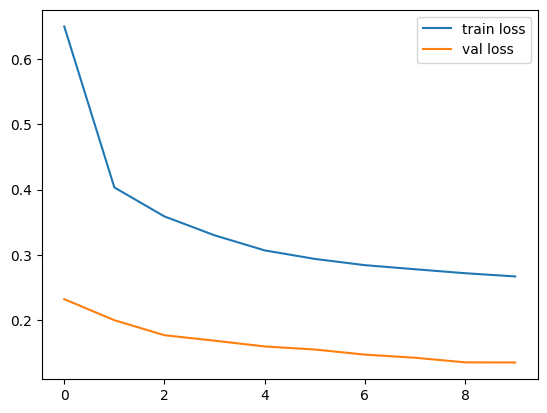

In [37]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend();

## Использование модели

In [38]:
x_test[0].shape
# x_test[0][None].shape razdutaja razmernost, pereshli v razmernost batcha

(28, 28)

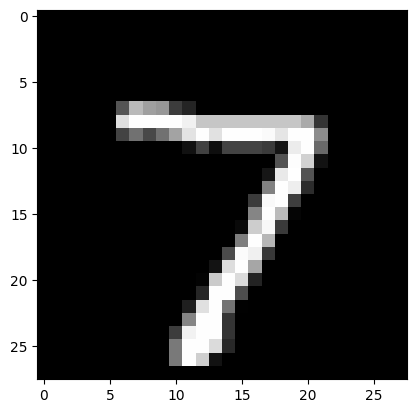

In [39]:
plt.imshow(x_test[0], cmap='gray');

In [40]:
predictions = model.predict(x_test[0][None]) # predskazannqe znachenija logitq, tk ne stavili funkziju aktivazii
predictions

1/1 [==============================] - 0s 117ms/step


array([[ -7.7221193, -10.148028 ,  -1.0632683,  -1.7473245, -16.412792 ,
         -4.8420196, -18.372766 ,   9.471508 ,  -5.444105 ,  -5.8631315]],
      dtype=float32)

In [41]:
probas = keras.layers.Softmax()(predictions)
probas # verjostanost bqt 7

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[3.4110261e-08, 3.0152636e-09, 2.6594187e-05, 1.3418539e-05,
        5.7355271e-12, 6.0770924e-07, 8.0791802e-13, 9.9995875e-01,
        3.3282319e-07, 2.1889345e-07]], dtype=float32)>

In [42]:
np.argmax(probas)

7

In [43]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 886us/step - loss: 0.1324 - accuracy: 0.9589


[0.13239386677742004, 0.958899974822998]

## Сохранение модели

 `model.save()` при вызове сохраняет модель в один файл.
Сохраненный файл включает в себя:
- архитектуру модели;
- веса модели;
- config-file (если такой был создан при компиляции);
- оптимизатор и его состояние.

In [44]:
model.save("path_to_my_model") # model.save("path_to_my_model.h5") cherez rashirenije, ctobq sohranilsja 1 fail, a ne papka
del model
# Recreate the exact same model purely from the file:
model = keras.models.load_model("path_to_my_model")

INFO:tensorflow:Assets written to: path_to_my_model/assets


In [45]:
model.summary()

Model: "our_first_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten_1 (Flatten)            (None, 784)          0           ['input_4[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 32)           25120       ['flatten_1[0][0]']              
                                                                                                  
 dense_7 (Dense)                (None, 32)           25120       ['flatten_1[0][0]']              
                                                                                    

In [46]:
# Save the weights to disk
model.save_weights('model_weights.h5')

In [47]:
# sohranjajem kobfiguraziju modeli, vsega idjot s sohranenijem vesov
config_mnist = model.get_config()
config_mnist

{'name': 'our_first_model',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 28, 28),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_4'},
   'name': 'input_4',
   'inbound_nodes': []},
  {'class_name': 'Flatten',
   'config': {'name': 'flatten_1',
    'trainable': True,
    'dtype': 'float32',
    'data_format': 'channels_last'},
   'name': 'flatten_1',
   'inbound_nodes': [[['input_4', 0, 0, {}]]]},
  {'class_name': 'Dense',
   'config': {'name': 'dense_6',
    'trainable': True,
    'dtype': 'float32',
    'units': 32,
    'activation': 'linear',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'dense_6',
   'inbound_nodes':

In [48]:
keras.models.load_model('model_weights.h5')  # ValueError: No model found in config file

ValueError: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x7fd8409667a0>.

In [49]:
# Load the model weights from disk
model.from_config(config_mnist) # schitali model , ee arhitekturu
model.load_weights('model_weights.h5') # schitali v model vesa 

In [50]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 949us/step - loss: 0.1324 - accuracy: 0.9589


[0.13239386677742004, 0.958899974822998]

# Дополнительные материалы

1. Переобучение и недообучение - https://youtu.be/m7P7bnLxIc4
2. Метрики для задачи регрессии - https://youtu.be/vh2smjQyhp8
3. Метрики для задачи классификации - https://youtube.com/playlist?list=PLkJJmZ1EJno6CLyvD4DHc32Fed6cPBHje

